In the previous file, we introduced the `EXPLAIN` command with its option `ANALYZE` and demonstrated how to benchmark queries. Using `EXPLAIN` and `ANALYZE`, we evaluated estimated and actual query plan results and compared the difference between them. Finally, we ended by benchmarking a `SELECT` query with the `JOIN` clause between two tables to estimate the query speed costs incurred by joins.

In this file, we will learn strategies to make queries more efficient. Remember that our role as a data engineer is, in part, to build the data infrastructure so that data become available for everyone in the company. Companies and other institutions have non-engineers who want to query databases. These people have their own skill set and responsibilities and often don't know how a database works internally. Therefore it is our duty to ensure that their queries run smoothly and as fast as possible.

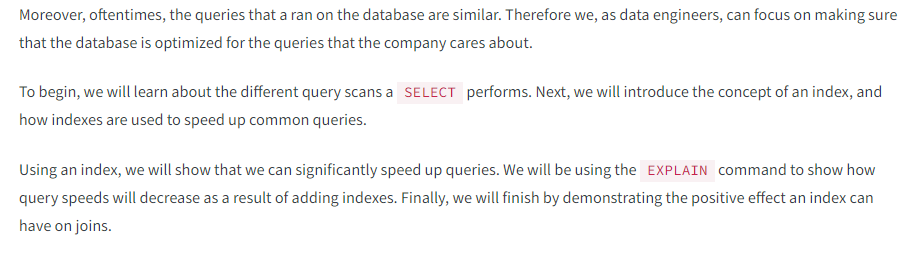

**Task**

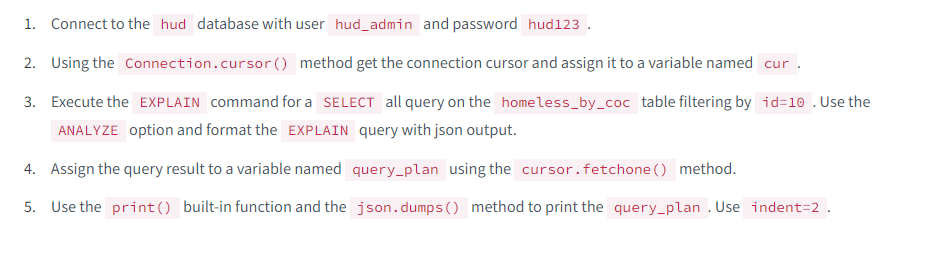

**Answer**

`import psycopg2
import json
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json) 
    SELECT * FROM homeless_by_coc
    WHERE id = 10;
""")`

`query_plan = cur.fetchone()
print(json.dumps(query_plan, indent=2))`

Below is the output from the query plan produced above.

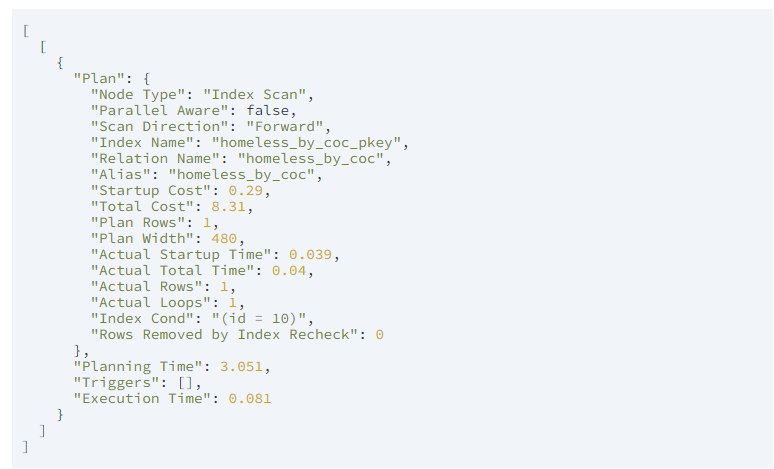

We will notice that this query plan has a new node type called `Index Scan` — different from the usual `Seq Scan` in `SELECT *` queries that we have seen before. This type of scan contains another key, the `"Index Name"`, with the value `"homeless_by_coc_pkey"`. The postfix of the value, `pkey`, is short for `primary key`.

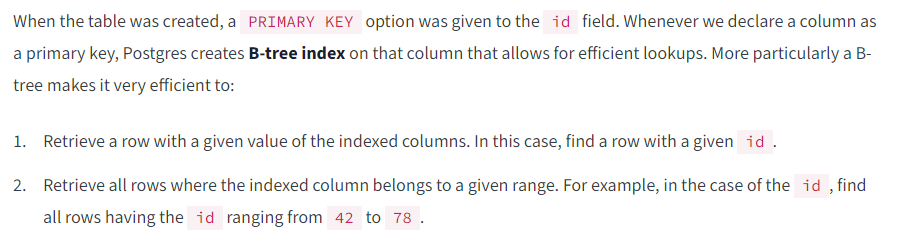

We are not going to delve into the details of how a B-tree works internally for now. For now, we can imagine it as searching a certain information in a book. We can imagine a sequential scan as reading the whole book to find it. It works, but it is very time consuming. Another way is to look in the table of contents and pinpoint exactly the page where the information is located.

Let's compare the time needed to fetch one row by using the `id` column against the time needed to fetch the same row using the `coc_name` column from the `homeless_by_coc` table. For this we selected an arbitrary row in the middle of the table and ask to `EXPLAIN` both queries.

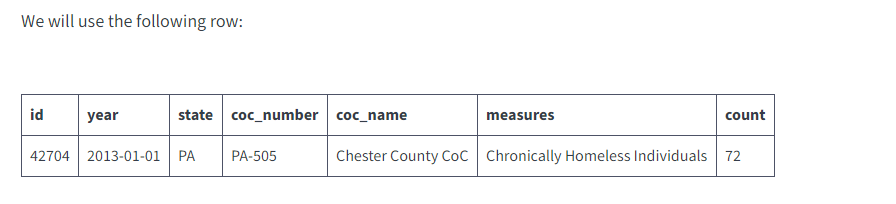

In order to compare the runtime, we are going to use the `ANALYZE` option and then lookup the "Execution Time" field for each query plan. As we can see in the output from above, this field is nested within two lists. We thus obtain it by doing the following:

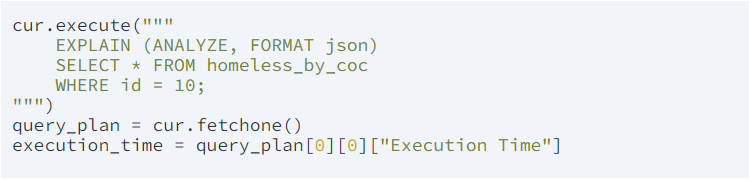

**Task**

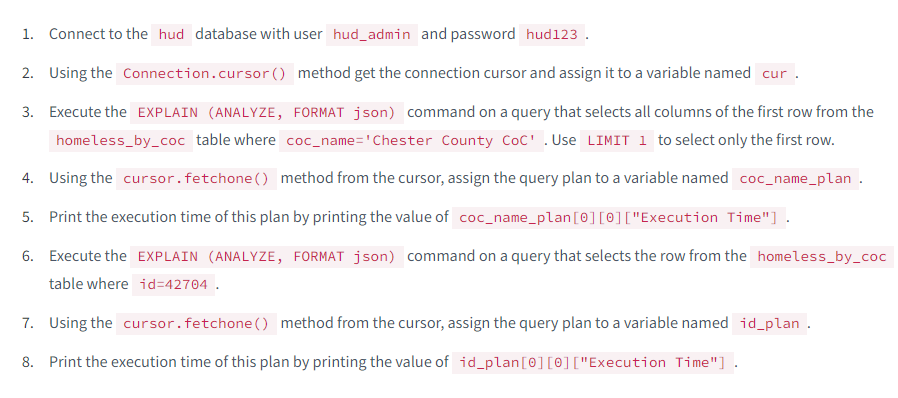

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json) 
    SELECT * FROM homeless_by_coc 
    WHERE coc_name = 'Chester County CoC'
    LIMIT 1;
""")`

`coc_name_plan = cur.fetchone()
print(coc_name_plan[0][0]["Execution Time"])`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json) 
    SELECT * FROM homeless_by_coc 
    WHERE id = 42704;
""")`

`id_plan = cur.fetchone()
print(id_plan[0][0]["Execution Time"])`

We saw above that, when we queried using the `id` field, the runtime was significantly lower than when querying the same row using the `coc_name` field.

The values that we obtained where roughly (exact values can change from one execution to another):

`0.408 # coc_name query time
0.038 # id query time (much faster)`

The reason for this difference is that, as we explained above, the `id` column is set as a primary key and therefore has an index associated to it, which allows for quick lookups.

When we learn about B-trees, we will see that the number of rows we need to lookup in order to find a given row using an `Index Scan` is roughly 
$log_
2
(
N
)$
 where 
**N**
 is the number of rows in the table. In contrast, when performing a `Seq Scan` we need, as we mentioned previously, to inspect each an every row from the table.

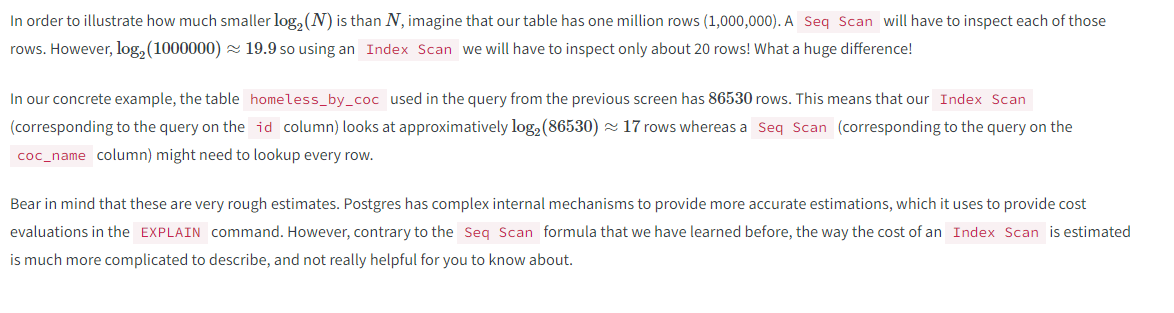

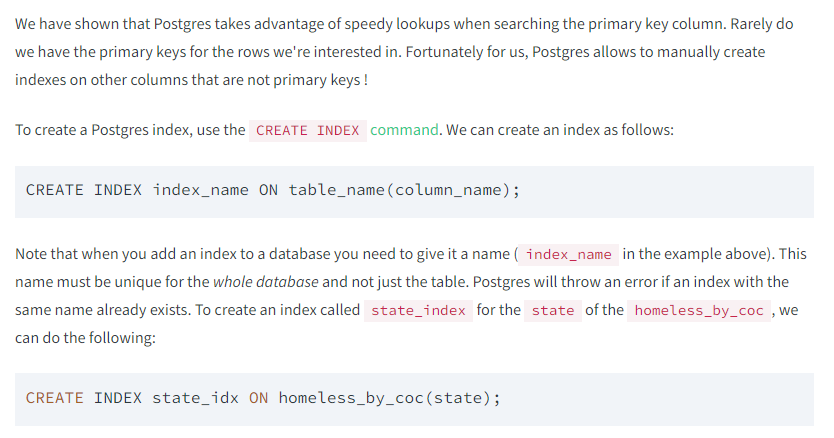

While having indexes can give us tremendous speed benefits, they come at the cost of space. Each index needs to be stored in a file. In addition, adding, editing, and deleting rows takes longer, since each of the affected indexes needs to be updated.

Let's create an index for the `coc_name` column.

**Task**

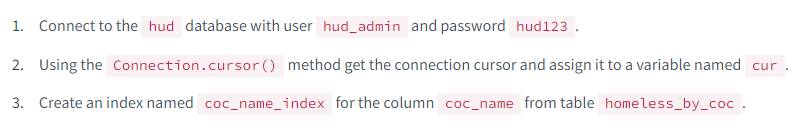

**Answer**

`import psycopg2
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    CREATE INDEX coc_name_index ON homeless_by_coc(coc_name);
""")`

`conn.commit()
conn.close()`

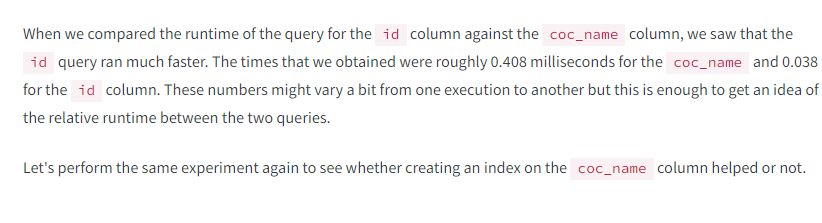

**Task**

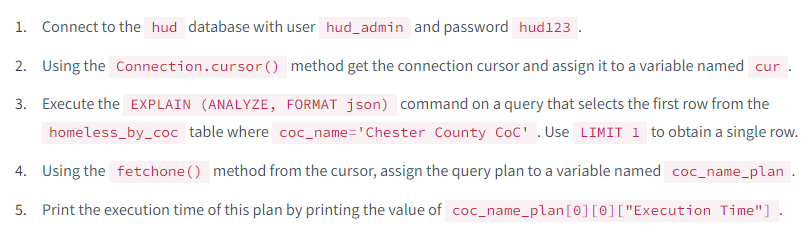

**Answer**

`import psycopg2
import json
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json) 
    SELECT * FROM homeless_by_coc 
    WHERE coc_name = 'Chester County CoC'
    LIMIT 1;
""")`

`coc_name_plan = cur.fetchone()
print(coc_name_plan[0][0]["Execution Time"])`

We can see from above that using an index on the `coc_name` columns reduced the runtime from about 0.4 milliseconds to about 0.1 milliseconds (four time faster!).

We mentioned that although indexes significantly speedup queries they are costly in terms of storage space. Also, having an index is not always beneficial. If a query needs to return a lot of results the index might be as slow as performing a sequential scan. The reason for this is that in such cases the index will find the first result very quickly but then it will still needs to iterate over all the rows that it needs to retrieve.

An index is good at very quickly finding where the results are located, but it will still need to iterate over all the results to retrieve them. We can think of it as a table of contents in a book. If we want to read the whole book, there is no need to spend time looking at the table of contents to see where each chapter is located; just skip the table of contents and start reading the book from the first chapter.

Productions databases can become very large and evolve over time. Thus, it useful to know how to find a list of all existing indexes so that we can:

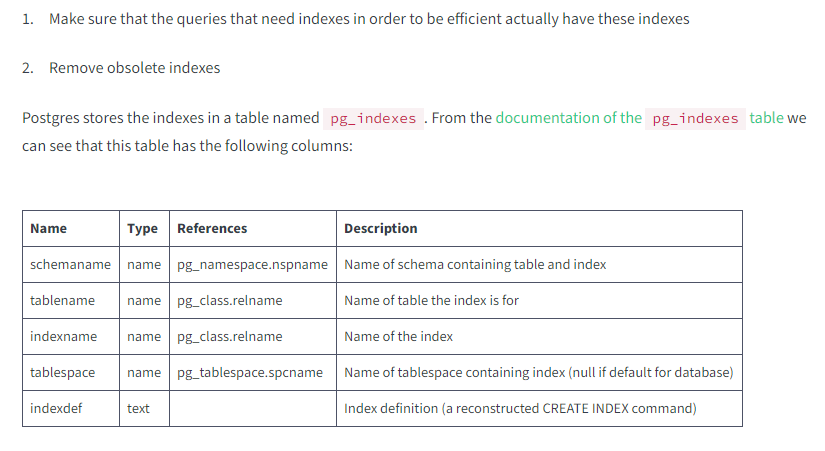

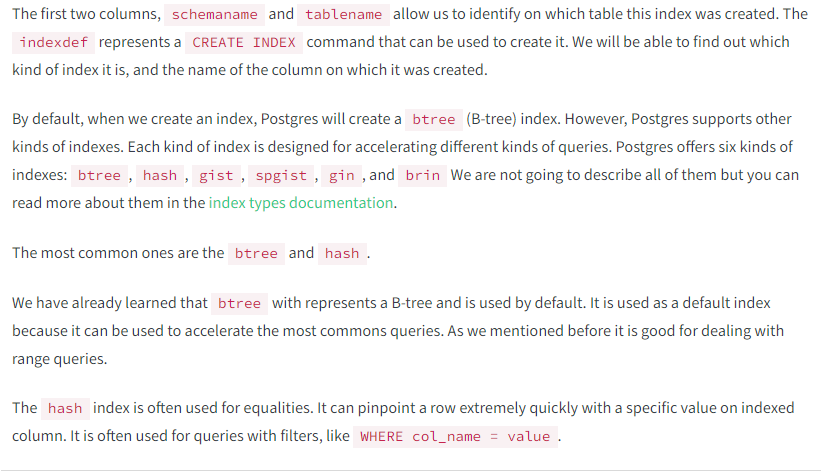

Let's verify that the index we created above is indeed in the `pg_indexes` table.

**Task**

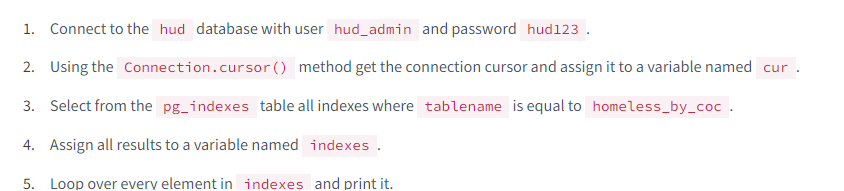

We should get two indexes, the one that we have explicitly created above and the one Postgres created for the primary key `id` column.

**Answer**

`import psycopg2
import json
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    SELECT * FROM pg_indexes
    WHERE tablename = 'homeless_by_coc';
""")`

`indexes = cur.fetchall()
for index in indexes:
    print(index)`

We mentioned previously that we oftentimes want to delete an index either because it is using too much unnecessary space or because it simply is not needed anymore because the nature of the queries changed.

Similar to `DROP TABLE`, Postgres has a command that we use to delete our indexes. If we want to remove an index from our table, we can run the following command:

`DROP INDEX example_name;`

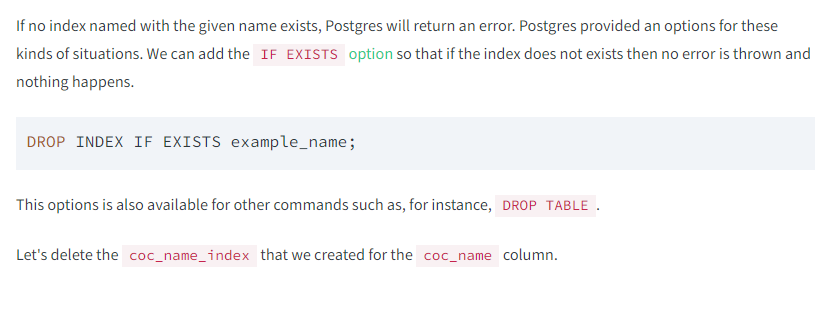

**Task**

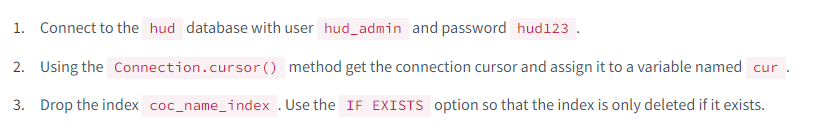

**Answer**

`import psycopg2
import json
conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    DROP INDEX IF EXISTS coc_name_index;
""")`

`conn.commit()
conn.close()`

Let's analyze the speed-up of having an index for an inner join query. On the last file, we performed the following query:

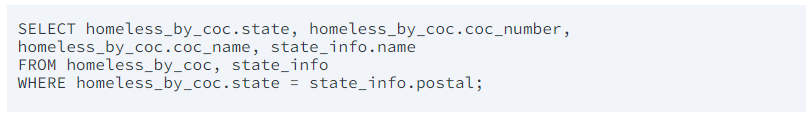

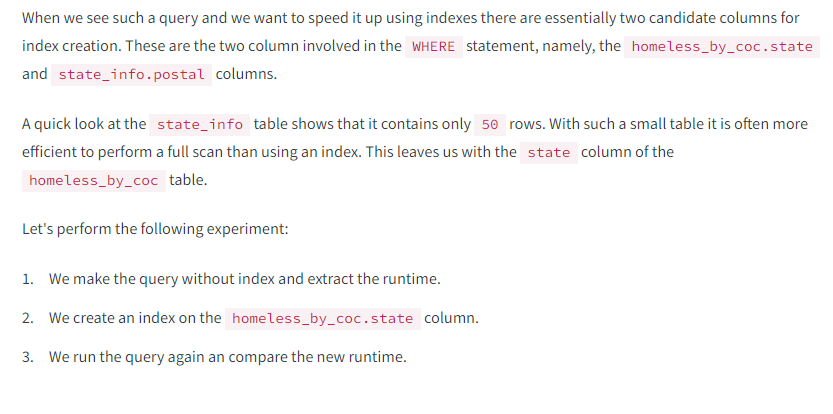

**Task**

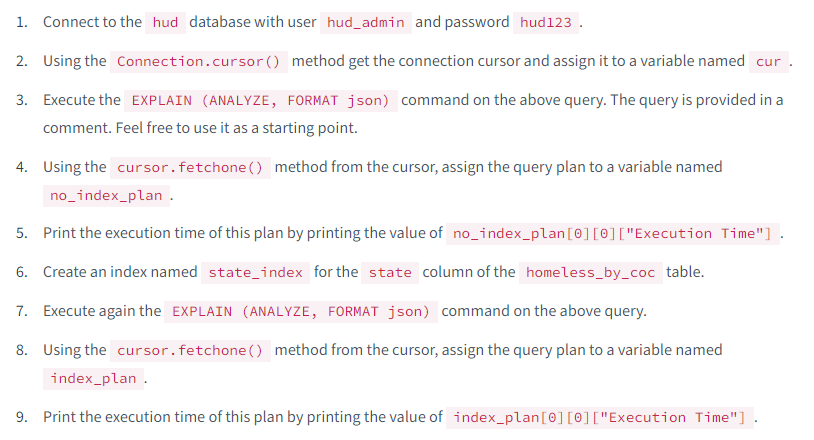

**Answer**


`import psycopg2
import json`

`"""
EXPLAIN (ANALYZE, FORMAT json)
SELECT homeless_by_coc.state, homeless_by_coc.coc_number, homeless_by_coc.coc_name, state_info.name 
FROM homeless_by_coc, state_info
WHERE homeless_by_coc.state = state_info.postal;
"""`

`conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`


`# query without index`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json)
    SELECT homeless_by_coc.state, homeless_by_coc.coc_number, homeless_by_coc.coc_name, state_info.name 
    FROM homeless_by_coc, state_info
    WHERE homeless_by_coc.state = state_info.postal;
""")`

`no_index_plan = cur.fetchone()
print(no_index_plan[0][0]["Execution Time"])`

`# create the index`

`cur.execute("CREATE INDEX state_index ON homeless_by_coc(state)")`

`# query with index`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json)
    SELECT homeless_by_coc.state, homeless_by_coc.coc_number, homeless_by_coc.coc_name, state_info.name 
    FROM homeless_by_coc, state_info
    WHERE homeless_by_coc.state = state_info.postal;
""")`

`index_plan = cur.fetchone()
print(index_plan[0][0]["Execution Time"])`

`conn.commit()`

We have run the experiment five times and got the following runtimes:

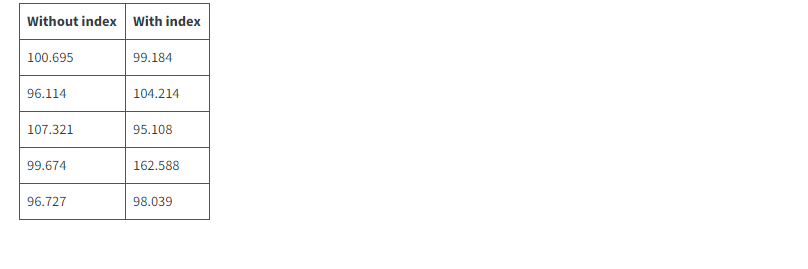

As we can see there is not a clear winner and the runtimes are actually quite similar. Using an index can even be slower sometimes with this query. If we take a look at both query plans, we will see that they are actually the same ! So Postgres decided to not use the `state_index` at all.

Let's understand why this is. If we actually run the query and count the number of rows in the result we get the following:

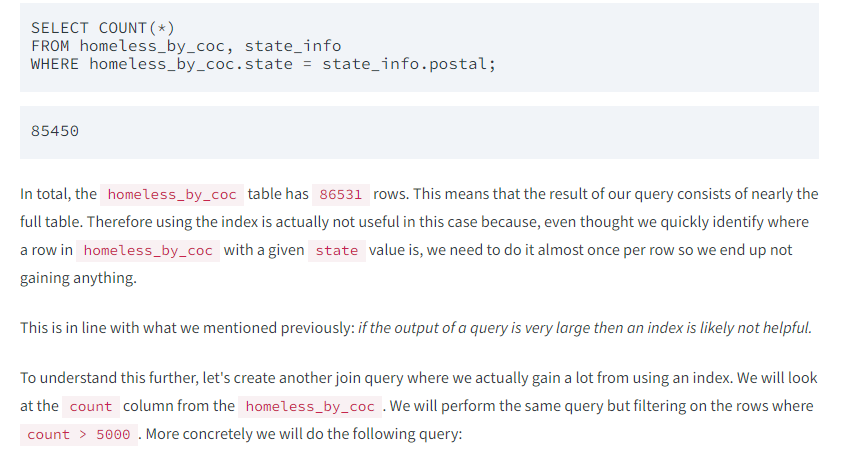

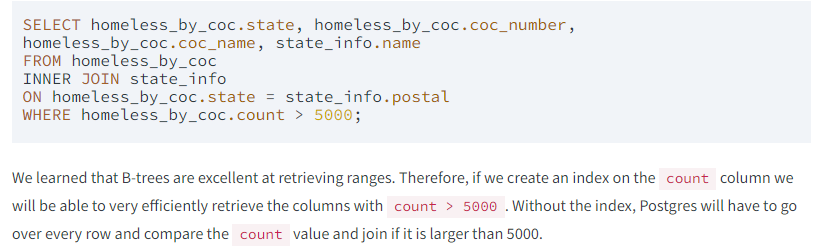

So let's do the experiment. To ensure that the performance gain comes from the new index, we have deleted the `state_index` index that we have created earlier.

**Task**

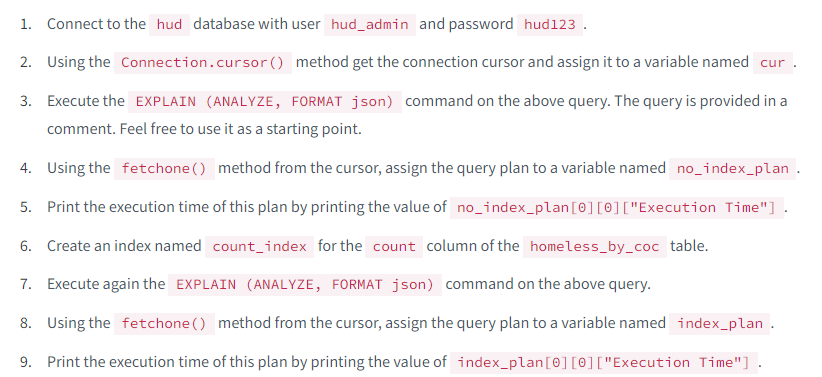

**Answer**

`import psycopg2
import json`

`"""
EXPLAIN (ANALYZE, FORMAT json)
SELECT homeless_by_coc.state, homeless_by_coc.coc_number, homeless_by_coc.coc_name, state_info.name
FROM homeless_by_coc
INNER JOIN state_info
ON homeless_by_coc.state = state_info.postal
WHERE homeless_by_coc.count > 5000;
"""`

`conn = psycopg2.connect(dbname='hud', user='hud_admin', password='hud123')
cur = conn.cursor()`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json)
    SELECT homeless_by_coc.state, homeless_by_coc.coc_number, homeless_by_coc.coc_name, state_info.name
    FROM homeless_by_coc
    INNER JOIN state_info
    ON homeless_by_coc.state = state_info.postal
    WHERE homeless_by_coc.count > 5000;
""")`

`no_index_plan = cur.fetchone()
print(no_index_plan[0][0]["Execution Time"])`

`cur.execute("CREATE INDEX count_index ON homeless_by_coc(count)")`

`cur.execute("""
    EXPLAIN (ANALYZE, FORMAT json)
    SELECT homeless_by_coc.state, homeless_by_coc.coc_number, homeless_by_coc.coc_name, state_info.name
    FROM homeless_by_coc
    INNER JOIN state_info
    ON homeless_by_coc.state = state_info.postal
    WHERE homeless_by_coc.count > 5000;
""")`

`index_plan = cur.fetchone()
print(index_plan[0][0]["Execution Time"])`

`conn.commit()`

We saw above that, as we predicted, using an index on the count column actually provides a huge performance boost!

So what have we learned in this file? We have learned:

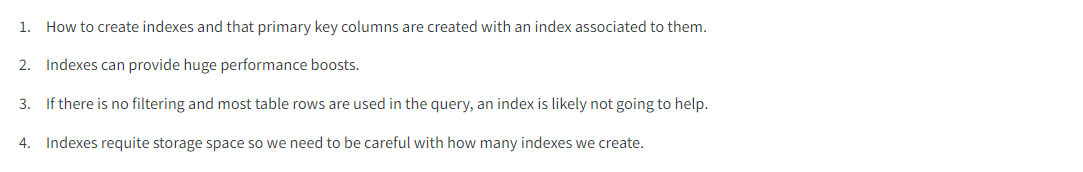

In the next file we will learn how Postgres choses which kind of scan to perform. We will learn about other kind of scans and how to create indexes on multiple columns.